In [145]:
# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
plt.switch_backend('agg')  # needed for saving figures
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
import pylab
from cycler import cycler
import seaborn as sns
import os
import multiprocessing

%matplotlib inline

# this chemkin file is from the cti generated by rmg
gas = ct.Solution('./chem_annotated.cti', 'gas')
surf = ct.Interface('./chem_annotated.cti', 'surface1', [gas])

print("This mechanism contains {} gas reactions and {} surface reactions".format(gas.n_reactions, surf.n_reactions))

i_ar = gas.species_index('Ar')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

# unit conversion factors to SI
mm = 0.001
cm = 0.01
ms = mm
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################
t_in = 650  # K - in the paper, it was ~648.15K at the start of the cat surface for Rh
t_cat = t_in
length = 70 * mm  # Reactor length- m
diam = 16.5*mm  # Reactor diameter - in m
area = (diam/2.0)**2*np.pi  # Reactor cross section area (area of tube) in m^2
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
# cat_area_per_vol = 1600.  # Catalyst particle surface area per unit volume in m-1
cat_area_per_vol = 25000  # I made this up, in m-1
flow_rate = 4.7  # slpm
flow_rate = flow_rate*.001/60  # m^3/s
tot_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate/area  # m/s

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 7001

on_catalyst = 1000  # catalyst length 10mm, but it doesn't say where.  let's guess at 1 cm?
off_catalyst = 2000
dt = 1.0

reactor_len = length/(NReactors-1)
rvol = area * reactor_len * porosity

# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

This mechanism contains 38 gas reactions and 41 surface reactions


In [146]:
def plotZoom(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

    fig, axs = plt.subplots(1, 2)
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    for i in range(len(gas_out[0, :])):
        if i != i_ar:
            if gas_out[:, i].max() > 5.e-3:
                #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:, i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                    if species_name[-3] == '(':
                        species_name = species_name[0:-3]
                    else:
                        species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=14, color='y',
                                    xy=(dist_array[1100], gas_out[:, i][1100] + gas_out[:, i][1100] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=14, color='c',
                                    xy=(dist_array[2400], gas_out[:, i][2400] + gas_out[:, i][2400] / 10.0), va='bottom',
                                    ha='center')
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=14, color='g', xy=(dist_array[2100], gas_out[:, i][2100] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "H2":
                    axs[0].annotate("H$_2$", fontsize=14, color='k', xy=(dist_array[2200], gas_out[:, i][2200] - 0.001),
                                    va='top', ha='center')
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=14, color='b',
                                    xy=(dist_array[1100], gas_out[:, i][1100] + gas_out[:, i][1100] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=14, color='r',
                                    xy=(dist_array[2100], gas_out[:, i][2100] + gas_out[:, i][2100] / 40.0 + 0.001), va='bottom',
                                    ha='center')
                else:
                    axs[0].annotate(species_name, fontsize=14,
                                    xy=(dist_array[-1], gas_out[:, i][-1] + gas_out[:, i][-1] / 10.0), va='top',
                                    ha='center')
            else:
                axs[0].plot(0, 0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))
    # Plot two temperatures (of gas-phase and surface vs only surface.)
    # axs[1].plot(dist_array, T_array, label="temperature")
    ax2 = axs[0].twinx()
    ax2.plot(dist_array, T_array, label='temperature', color='r', linestyle=':')
    #     axs[1].plot(dist_array, T2_array, "--", label="surface reactions only")
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.175), va='bottom', ha='left')
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [600.0, 2000], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [600.0, 2000], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1800), va='bottom', ha='left')

    for item in (
            axs[0].get_xticklabels() + axs[0].get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(18)

    #axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0., 0.1)
    axs[1].set_ylim(600.0, 2000)
    axs[0].set_xlim(8, 25)
    axs[1].set_xlim(8, 25)
    axs[0].set_xlabel('Distance (mm)', fontsize=20)
    axs[1].set_xlabel('Distance (mm)', fontsize=20)  # axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=20)
    # axs[1].set_ylabel('Temperature (K)', fontsize=20)
    ax2.set_ylabel('Temperature (K)', fontsize=20)
    ax2.set_ylim(600, 2000)
    ax2.set_xlim(8, 25)
    # fig.tight_layout()
    # axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    fig.delaxes(axs[1])  # THIS DELETES THE EXTRA SUBPLOT!
    fig.set_figheight(6)
    fig.set_figwidth(24)

    #     temperature = np.round(T_array[0],0)
    for n in range(len(gas_names)):
        if gas_names[n] == 'CH4(2)':
            c_in = gas_out[0][n]
        if gas_names[n] == 'O2(3)':
            o_in = gas_out[0][n]
    ratio = c_in / (o_in * 2)
    ratio = round(ratio, 1)
    
    out_dir = 'figures'
    os.path.exists(out_dir) or os.makedirs(out_dir)
#     fig.savefig(out_dir + '/' + str(ratio) + 'ratioZoom.png', bbox_inches='tight')

def plotSurf(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

    fig, axs = plt.subplots(1, 2)
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    for i in range(len(gas_out[0, :])):
        if i != i_ar:
            if gas_out[:, i].max() > 5.e-3:
                #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:, i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                    if species_name[-3] == '(':
                        species_name = species_name[0:-3]
                    else:
                        species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 10.0), va='top',
                                    ha='center')
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=12, xy=(dist_array[2200], gas_out[:, i][2200] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[2200], gas_out[:, i][2200] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 40.0), va='top',
                                    ha='center')
                else:
                    axs[0].annotate(species_name, fontsize=12,
                                    xy=(dist_array[-1], gas_out[:, i][-1] + gas_out[:, i][-1] / 10.0), va='top',
                                    ha='center')
            else:
                axs[0].plot(0, 0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))
    # Plot two temperatures (of gas-phase and surface vs only surface.)
    for i in range(len(surf_out[0, :])):
        if surf_out[:, i].max() > 5.e-3:
            axs[1].plot(dist_array, surf_out[:, i], label=surf_names[i])
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.175), va='bottom', ha='left')
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.2], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.2], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1.1), va='bottom', ha='left')

    for item in (
            axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0., 0.1)
    axs[1].set_ylim(0, 1.2)  # change back to 1.2
    axs[0].set_xlim(5, 25)
    axs[1].set_xlim(5, 25)
    axs[0].set_xlabel('Distance (mm)', fontsize=13)
    axs[1].set_xlabel('Distance (mm)', fontsize=13)  # axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=13)
    axs[1].set_ylabel('Site fraction', fontsize=13)
    # fig.tight_layout()
    # axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    fig.delaxes(axs[0])  # THIS DELETES THE EXTRA SUBPLOT!

    fig.set_figheight(6)
    fig.set_figwidth(18)

    #     temperature = np.round(T_array[0],0)
    for n in range(len(gas_names)):
        if gas_names[n] == 'CH4(2)':
            c_in = gas_out[0][n]
        if gas_names[n] == 'O2(3)':
            o_in = gas_out[0][n]
    ratio = c_in / (o_in * 2)
    ratio = round(ratio, 1)

    out_dir = 'figures'
    os.path.exists(out_dir) or os.makedirs(out_dir)
    fig.savefig(out_dir + '/' + str(ratio) + 'surf.pdf', bbox_inches='tight')

def monolithFull(gas, surf, temp, mol_in, verbose=False, sens=False):
    """
    Verbose prints out values as you go along
    Sens is for sensitivity, in the form [perturbation, reaction #]
    """
    ch4, o2, ar = mol_in
    ratio = ch4/(2*o2)
    ratio = round(ratio, 1)
    ch4 = str(ch4)
    o2 = str(o2)
    ar = str(ar)
    X = str('CH4(2):' + ch4 + ', O2(3):' + o2 + ', Ar:' + ar)
    gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
    # mass_flow_rate = velocity * gas.density_mass * area  # kg/s
    mass_flow_rate = flow_rate * gas.density_mass
    gas.TPX = temp, ct.one_atm, X
    temp_cat = temp
    surf.TP = temp_cat, ct.one_atm
    surf.coverages = 'X(1):1.0'
    gas.set_multiplier(1.0)

    TDY = gas.TDY
    cov = surf.coverages

    if verbose is True:
        print('  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

    # create a new reactor
    gas.TDY = TDY
    r = ct.IdealGasReactor(gas)
    r.volume = rvol

    # create a reservoir to represent the reactor immediately upstream. Note
    # that the gas object is set already to the state of the upstream reactor
    upstream = ct.Reservoir(gas, name='upstream')

    # create a reservoir for the reactor to exhaust into. The composition of
    # this reservoir is irrelevant.
    downstream = ct.Reservoir(gas, name='downstream')

    # Add the reacting surface to the reactor. The area is set to the desired
    # catalyst area in the reactor.
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # The mass flow rate into the reactor will be fixed by using a
    # MassFlowController object.
    # mass_flow_rate = velocity * gas.density_mass * area  # kg/s
    # mass_flow_rate = flow_rate * gas.density_mass
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

    # We need an outlet to the downstream reservoir. This will determine the
    # pressure in the reactor. The value of K will only affect the transient
    # pressure difference.
    v = ct.PressureController(r, downstream, master=m, K=1e-5)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-10
    sim.atol = 1.0e-20

    gas_names = gas.species_names
    surf_names = surf.species_names
    gas_out = []  # in

    surf_out = []
    dist_array = []
    T_array = []

    surf.set_multiplier(0.0)  # no surface reactions until the gauze
    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY = r.thermo.TDY
        upstream.syncState()
        if n == on_catalyst:
            surf.set_multiplier(1.0)
            if sens is not False:
                surf.set_multiplier(1.0 + sens[0], sens[1])
        if n == off_catalyst:
            surf.set_multiplier(0.0)
        sim.reinitialize()
        sim.advance_to_steady_state()
        dist = n * reactor_len * 1.0e3  # distance in mm
        dist_array.append(dist)
        T_array.append(surf.T)
        # print "mass_flow_rate", mass_flow_rate,  v.mdot(sim.time), "kg/s"
        kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
        gas_out.append(1000 * 60 * kmole_flow_rate * gas.X.copy())  # molar flow rate in moles/minute
        surf_out.append(surf.X.copy())

        # make reaction diagrams
        out_dir = 'rxnpath'
        os.path.exists(out_dir) or os.makedirs(out_dir)
        elements = ['H', 'O']
        locations_of_interest = [1000, 1150, 1160, 1183, 1196, 1999]
        if sens is False:
            for l in locations_of_interest:
                if n == l:
                    location = str(n / 100)
        
                    diagram = ct.ReactionPathDiagram(surf, 'X')
                    diagram.title = 'rxn path'
                    diagram.label_threshold = 1e-9
                    dot_file = out_dir + '/rxnpath-' + str(ratio) + '-x-' + location + 'mm.dot'
                    img_file = out_dir + '/rxnpath-' + str(ratio) + '-x-' + location + 'mm.png'
                    img_path = os.path.join(out_dir, img_file)
                    diagram.write_dot(dot_file)
                    os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
        
                    for element in elements:
                        diagram = ct.ReactionPathDiagram(surf, element)
                        diagram.title = element + 'rxn path'
                        diagram.label_threshold = 1e-9
                        dot_file = out_dir + '/rxnpath-' + str(ratio) + '-surf-' + location + 'mm-' + element + '.dot'
                        img_file = out_dir + '/rxnpath-' + str(ratio) + '-surf-' + location + 'mm-' + element + '.png'
                        img_path = os.path.join(out_dir, img_file)
                        diagram.write_dot(dot_file)
                        os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
        else:
            pass

        if verbose is True:
            if not n % 100:
                print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist, *gas[
                    'CH4(2)', 'O2(3)', 'H2(6)', 'CO(7)', 'H2O(5)', 'CO2(4)'].X * 1000 * 60 * kmole_flow_rate))
                # print(surf.T)
                # print(gas.P)
                # print(surf.coverages)

    gas_out = np.array(gas_out)
    surf_out = np.array(surf_out)
    gas_names = np.array(gas_names)
    surf_names = np.array(surf_names)
    data_out = gas_out, surf_out, gas_names, surf_names, dist_array, T_array
    return data_out



In [147]:
ratio = 1.0
fo2 = 1 / (2. * ratio + 1 + 79 / 21)
fch4 = 2 * fo2 * ratio
far = 79 * fo2 / 21
ratio_in = [fch4, fo2, far]  # mol fractions

a = monolithFull(gas, surf, t_in, ratio_in, verbose=True)
gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    1.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    2.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    3.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    4.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    5.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    6.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    7.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    8.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
    9.000000    0.062021    0.031011    0.000000   0.000000   0.000000   0.000000
   10.000000    0.062019    0.031007    0.000000   0.000000   0.000004   0.000001
   11.000000    

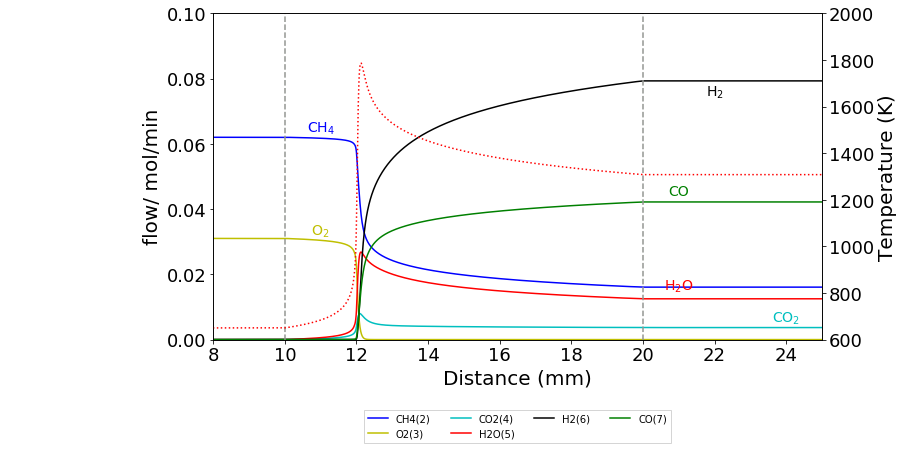

In [148]:
plotZoom(a)

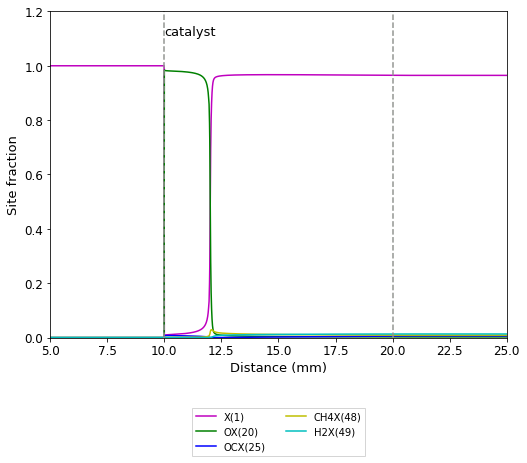

In [149]:
plotSurf(a)

In [155]:
def deriv(p):
    deriv = []
    for x in xrange(7000):
        deriv.append((p[x+1] - p[x])/.01)
    deriv.append(0.)
    return deriv

methane = gas_out[:,3] # ch4 conc
oxygen = gas_out[:,4]
hydrogen = gas_out[:,7]
co2 = gas_out[:,5]
co = gas_out[:,8]
h2o = gas_out[:,6]

d_ch4 = deriv(methane)
d_o2 = deriv(oxygen)
d_h2 = deriv(hydrogen)
d_co2 = deriv(co2)
d_co = deriv(co)
d_h2o = deriv(h2o)

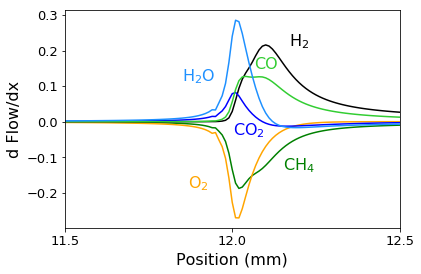

In [177]:
plt.plot(dist_array,d_ch4,color='green')
plt.plot(dist_array,d_o2,color='orange')
plt.plot(dist_array,d_h2,color='k')
plt.plot(dist_array,d_co2,color='blue')
plt.plot(dist_array,d_co,color='limegreen')
plt.plot(dist_array,d_h2o,color='dodgerblue')

plt.annotate("CH$_4$", fontsize=16, color='g',
            xy=(dist_array[1220], -.15),
            va='bottom', ha='center')
plt.annotate("O$_2$", fontsize=16, color='orange',
            xy=(dist_array[1190], -.2),
            va='bottom', ha='center')
plt.annotate("H$_2$", fontsize=16, color='k',
            xy=(dist_array[1220], .2),
            va='bottom', ha='center')
plt.annotate("CO", fontsize=16, color='limegreen',
            xy=(dist_array[1210], .14),
            va='bottom', ha='center')
plt.annotate("CO$_2$", fontsize=16, color='blue',
            xy=(dist_array[1205], -0.05),
            va='bottom', ha='center')
plt.annotate("H$_2$O", fontsize=16, color='dodgerblue',
            xy=(dist_array[1190], .1),
            va='bottom', ha='center')

plt.xlabel('Position (mm)', fontsize=16)
plt.ylabel('d Flow/dx', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(np.arange(11.5,14,0.5))
plt.xlim(11.5,12.5)
plt.savefig('./paperplots/deriv.pdf',bbox_inches='tight',dpi=300)

In [178]:
#first peak
print d_h2o.index(max(d_h2o))
print d_co2.index(max(d_co2))
print d_o2.index(min(d_o2))
#second peak
print d_co.index(max(d_co))
print d_h2.index(max(d_h2))
print d_ch4.index(min(d_ch4))

1201
1201
1202
1204
1210
1202


In [179]:
temp_profile = np.array([ # [reactor location (mm), temperature (K)]
        [0.,373.15],
        [1.,373.15],
        [2.,373.15],
        [3.,373.15],
        [4.,373.15],
        [5.,373.15],
        [6.,413.15],
        [7.,448.15],
        [8.,473.15],
        [9.,548.15],
        [10.,648.15],
        [11.,963.15],
        [12.,1133.15],
        [13.,1173.15],
        [14.,1163.15],
        [15.,1123.15],
        [16.,1098.15],
        [17.,1073.15],
        [18.,1068.15],
        [19.,1063.15],
        [20.,1048.15],
        [21.,1033.15],
        [22.,1028.15],
        [23.,1023.15],
        [24.,1023.15],
        [25.,1023.15],])

ch4_in = 21/71*.208
ch4_profile = np.array([
        [0.,ch4_in],
        [1.,ch4_in],
        [2.,ch4_in],
        [3.,ch4_in],
        [4.,ch4_in],
        [5.,ch4_in],
        [6.,ch4_in],
        [7.,ch4_in],
        [8.,ch4_in],
        [9.,ch4_in],
        [10.,ch4_in],
        [10.25,0.059],
        [10.5,0.048],
        [10.75,0.041],
        [11.,0.036],
        [11.5,0.028],
        [12.,0.0225],
        [12.25,0.022],
        [12.5,0.021],
        [13.,0.021],
        [13.5,0.022],
        [14.,0.022],
        [14.5,0.021],
        [15.,0.019],
        [15.5,0.017],
        [16.,0.016],
        [17.,0.016],
        [18.,0.015],
        [19.,0.015],
        [20.,0.015],
        [21.,0.014],
        [22.,0.014],
        [23.,0.014],
        [24.,0.014],
        [25.,0.014],])

o2_in = (1 / (2. + 1 + 79 / 21)) * .208
o2_profile = np.array([
        [0.,o2_in],
        [1.,o2_in],
        [2.,o2_in],
        [3.,o2_in],
        [4.,o2_in],
        [5.,o2_in],
        [6.,o2_in],
        [7.,o2_in],
        [8.,o2_in],
        [9.,o2_in],
        [9.5,o2_in],
        [9.75,o2_in],
        [10.,o2_in],
        [10.1,0.028],
        [10.25,0.022],
        [10.5,0.013],
        [10.75,0.008],
        [11.,0.004],
        [11.25,0.001],
        [11.5,0.],
        [12.,0.],
        [13.,0.],
        [14.,0.],
        [15.,0.],
        [16.,0.],
        [17.,0.],
        [18.,0.],
        [19.,0.],
        [20.,0.],
        [21.,0.],
        [22.,0.],
        [23.,0.],
        [24.,0.],
        [25.,0.],])

h2_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.034],
        [12.,0.051],
        [13.,0.065],
        [14.,0.071],
        [15.,0.083],
        [16.,0.089],
        [17.,0.0895],
        [18.,0.09],
        [19.,0.0905],
        [20.,0.091],
        [21.,0.092],
        [22.,0.092],
        [23.,0.092],
        [24.,0.092],
        [25.,0.092],])

co_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.026],
        [12.,0.035],
        [13.,0.04],
        [14.,0.036],
        [15.,0.04],
        [16.,0.044],
        [17.,0.045],
        [18.,0.045],
        [19.,0.045],
        [20.,0.045],
        [21.,0.045],
        [22.,0.045],
        [23.,0.045],
        [24.,0.045],
        [25.,0.045],])

h2o_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.025],
        [11.5,0.026],
        [12.,0.025],
        [12.5,0.022],
        [13.,0.019],
        [14.,0.011],
        [15.,0.009],
        [16.,0.009],
        [17.,0.009],
        [18.,0.008],
        [19.,0.008],
        [20.,0.008],
        [21.,0.008],
        [22.,0.008],
        [23.,0.008],
        [24.,0.008],
        [25.,0.008],])

co2_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [11.,0.002],
        [12.,0.002],
        [12.5,0.002],
        [13.,0.002],
        [14.,0.002],
        [15.,0.002],
        [16.,0.002],
        [17.,0.002],
        [18.,0.002],
        [19.,0.002],
        [20.,0.002],
        [21.,0.002],
        [22.,0.002],
        [23.,0.002],
        [24.,0.002],
        [25.,0.002],])

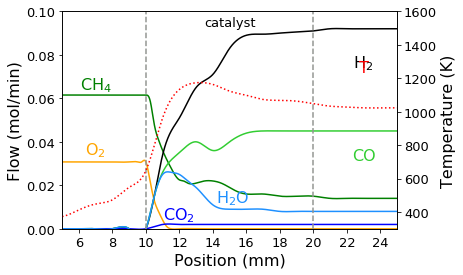

In [180]:
from scipy.interpolate import interp1d

dist = np.linspace(0,25,2501)
ch4 = interp1d(ch4_profile[:,0],ch4_profile[:,1],kind='cubic')
o2 = interp1d(o2_profile[:,0],o2_profile[:,1],kind='cubic')
h2 = interp1d(h2_profile[:,0],h2_profile[:,1],kind='cubic')
co = interp1d(co_profile[:,0],co_profile[:,1],kind='cubic')
h2o = interp1d(h2o_profile[:,0],h2o_profile[:,1],kind='cubic')
co2 = interp1d(co2_profile[:,0],co2_profile[:,1],kind='cubic')
temp = interp1d(temp_profile[:,0],temp_profile[:,1],kind='cubic')

plt.plot(dist,ch4(dist),color='g')
plt.annotate("CH$_4$", fontsize=16, color='g',
            xy=(dist_array[700], .062),
            va='bottom', ha='center')
plt.plot(dist,o2(dist),color='orange')
plt.annotate("O$_2$", fontsize=16, color='orange',
            xy=(dist_array[700], .032),
            va='bottom', ha='center')
plt.plot(dist,h2(dist),color='k')
plt.annotate("H$_2$", fontsize=16, color='k',
            xy=(dist_array[2300], .072),
            va='bottom', ha='center')
plt.plot(dist,co(dist),color='limegreen')
plt.annotate("CO", fontsize=16, color='limegreen',
            xy=(dist_array[2300], .03),
            va='bottom', ha='center')
plt.plot(dist,co2(dist),color='blue')
plt.annotate("CO$_2$", fontsize=16, color='blue',
            xy=(dist_array[1200], .002),
            va='bottom', ha='center')
plt.plot(dist,h2o(dist),color='dodgerblue')
plt.annotate("H$_2$O", fontsize=16, color='dodgerblue',
            xy=(dist_array[1520], .01),
            va='bottom', ha='center')
plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle='--', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle='--', color='xkcd:grey')
plt.annotate("catalyst", fontsize=13, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=16)
plt.xlabel('Position (mm)', fontsize=16)
plt.ylim((0,0.1))
plt.xlim((5,25))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(np.arange(6,26,2))

ax2 = plt.twinx()
ax2.plot(dist,temp(dist), ':', color='r')
ax2.set_ylim(300, 1600)
ax2.annotate("T",fontsize=16, color='r',
             xy=(dist_array[2300], 1310),
             va='top', ha='center')
ax2.set_ylabel('Temperature (K)', fontsize=16)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(13)
plt.savefig('./paperplots/horn_data.pdf',bbox_inches='tight',dpi=300)
plt.show()

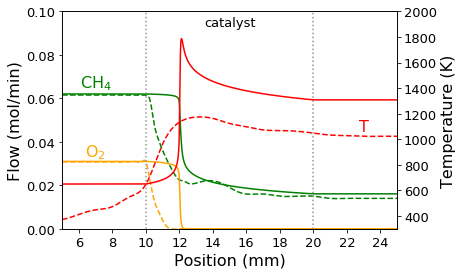

In [181]:
# plotting ch4
plt.plot(dist_array,gas_out[:,3], label=gas_names[3],color='g')
plt.annotate("CH$_4$", fontsize=16, color='g',
            xy=(dist_array[700], gas_out[:, 3][500] + gas_out[:, 3][500] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,ch4(dist),'--',color='g')
# plotting o2
plt.plot(dist_array,gas_out[:,4], label=gas_names[4],color='orange')
plt.annotate("O$_2$", fontsize=16, color='orange',
            xy=(dist_array[700], gas_out[:, 4][500] + gas_out[:, 4][500] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,o2(dist),'--',color='orange')

plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.annotate("catalyst", fontsize=13, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=16)
plt.xlabel('Position (mm)', fontsize=16)
plt.ylim((0,0.1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(np.arange(6,26,2))

ax2 = plt.twinx()
ax2.plot(dist,temp(dist), '--', color='r')
ax2.plot(dist_array,T_array,color='r')
ax2.annotate("T",fontsize=16, color='r',
             xy=(dist_array[2300], T_array[2300] -150),
             va='top', ha='center')
ax2.set_ylim(300, 2000)
ax2.set_ylabel('Temperature (K)', fontsize=16)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(13)

plt.xlim((5,25))  # cutting off where the horn paper cuts off the plots
plt.savefig('./paperplots/compare_ch4_o2_temp.pdf',bbox_inches='tight',dpi=300)
# plt.show()

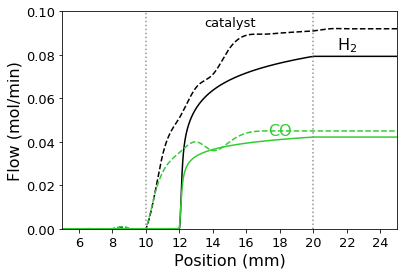

In [182]:
# plotting h2
plt.plot(dist_array,gas_out[:,7], label=gas_names[7],color='k')
plt.annotate("H$_2$", fontsize=16, color='k',
            xy=(dist_array[2200], gas_out[:, 7][2200] + gas_out[:, 7][2200] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,h2(dist),'--',color='k')
# plotting co
plt.plot(dist_array,gas_out[:,8], label=gas_names[8],color='limegreen')
plt.annotate("CO", fontsize=16, color='limegreen',
            xy=(dist_array[1800], gas_out[:, 8][1800] + gas_out[:, 8][1800] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,co(dist),'--',color='limegreen')

plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.annotate("catalyst", fontsize=13, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=16)
plt.xlabel('Position (mm)', fontsize=16)
plt.ylim((0,0.1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(np.arange(6,26,2))

plt.xlim((5,25))  # cutting off where the horn paper cuts off the plots
plt.savefig('./paperplots/compare_h2_co.pdf',bbox_inches='tight',dpi=300)
# plt.show()

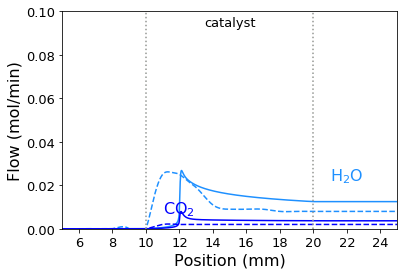

In [183]:
# plotting h2o
plt.plot(dist_array,gas_out[:,6], label=gas_names[6],color='dodgerblue')
plt.annotate("H$_2$O", fontsize=16, color='dodgerblue',
            xy=(dist_array[2200], 0.03 -.01),
            va='bottom', ha='center')
plt.plot(dist,h2o(dist),'--',color='dodgerblue')
# plotting co2
plt.plot(dist_array,gas_out[:,5], label=gas_names[5],color='blue')
plt.annotate("CO$_2$", fontsize=16, color='blue',
            xy=(dist_array[1200], .005),
            va='bottom', ha='center')
plt.plot(dist,co2(dist),'--',color='blue')

plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.annotate("catalyst", fontsize=13, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=16)
plt.xlabel('Position (mm)', fontsize=16)
plt.ylim((0,0.1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(np.arange(6,26,2))

plt.xlim((5,25))  # cutting off where the horn paper cuts off the plots
plt.savefig('./paperplots/compare_h2o_co2.pdf',bbox_inches='tight',dpi=300)
# plt.show()

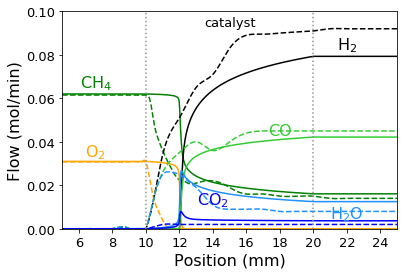

In [184]:
# plotting ch4
plt.plot(dist_array,gas_out[:,3], label=gas_names[3],color='g')
plt.annotate("CH$_4$", fontsize=16, color='g',
            xy=(dist_array[700], gas_out[:, 3][500] + gas_out[:, 3][500] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,ch4(dist),'--',color='g')
# plotting o2
plt.plot(dist_array,gas_out[:,4], label=gas_names[4],color='orange')
plt.annotate("O$_2$", fontsize=16, color='orange',
            xy=(dist_array[700], gas_out[:, 4][500] + gas_out[:, 4][500] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,o2(dist),'--',color='orange')
# plotting h2
plt.plot(dist_array,gas_out[:,7], label=gas_names[7],color='k')
plt.annotate("H$_2$", fontsize=16, color='k',
            xy=(dist_array[2200], gas_out[:, 7][2200] + gas_out[:, 7][2200] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,h2(dist),'--',color='k')
# plotting co
plt.plot(dist_array,gas_out[:,8], label=gas_names[8],color='limegreen')
plt.annotate("CO", fontsize=16, color='limegreen',
            xy=(dist_array[1800], gas_out[:, 8][1800] + gas_out[:, 8][1800] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,co(dist),'--',color='limegreen')
# plotting h2o
plt.plot(dist_array,gas_out[:,6], label=gas_names[6],color='dodgerblue')
plt.annotate("H$_2$O", fontsize=16, color='dodgerblue',
            xy=(dist_array[2200], gas_out[:, 6][2200] -.01),
            va='bottom', ha='center')
plt.plot(dist,h2o(dist),'--',color='dodgerblue')
# plotting co2
plt.plot(dist_array,gas_out[:,5], label=gas_names[5],color='blue')
plt.annotate("CO$_2$", fontsize=16, color='blue',
            xy=(dist_array[1400], .009),
            va='bottom', ha='center')
plt.plot(dist,co2(dist),'--',color='blue')

plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.annotate("catalyst", fontsize=13, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=16)
plt.xlabel('Position (mm)', fontsize=16)
plt.ylim((0,0.1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(np.arange(6,26,2))

# ax2 = plt.twinx()
# ax2.plot(dist,temp(dist), '--', color='r')
# ax2.plot(dist_array,T_array,color='r')
# ax2.annotate("T",fontsize=16, color='r',
#              xy=(dist_array[2300], T_array[2300] -150),
#              va='top', ha='center')
# ax2.set_ylim(300, 2000)
# ax2.set_ylabel('Temperature (K)', fontsize=16)
# for item in (ax2.get_yticklabels()):
#              item.set_fontsize(13)

plt.xlim((5,25))  # cutting off where the horn paper cuts off the plots
plt.savefig('./paperplots/all_compare.pdf
            ',bbox_inches='tight',dpi=300)
# plt.show()

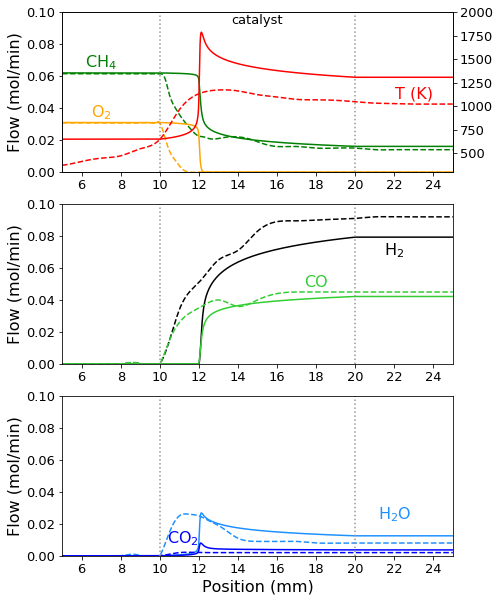

In [193]:
fig, axs = plt.subplots(3, 1)

# plotting ch4
axs[0].plot(dist_array,gas_out[:,3], label=gas_names[3],color='g')
axs[0].annotate("CH$_4$", fontsize=16, color='g',
            xy=(dist_array[700], gas_out[:, 3][500] + gas_out[:, 3][500] / 100.0),
            va='bottom', ha='center')
axs[0].plot(dist,ch4(dist),'--',color='g')
# plotting o2
axs[0].plot(dist_array,gas_out[:,4], label=gas_names[4],color='orange')
axs[0].annotate("O$_2$", fontsize=16, color='orange',
            xy=(dist_array[700], gas_out[:, 4][500] + gas_out[:, 4][500] / 100.0),
            va='bottom', ha='center')
axs[0].plot(dist,o2(dist),'--',color='orange')

axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[1500], 0.095), va='center', ha='center')

axs[0].set_ylabel('Flow (mol/min)', fontsize=16)
axs[0].set_ylim((0,0.1))
for item in (axs[0].get_xticklabels()):
             item.set_fontsize(13)
for item in (axs[0].get_yticklabels()):
             item.set_fontsize(13)
axs[0].set_xticks(np.arange(6,26,2))

ax2 = axs[0].twinx()
ax2.plot(dist,temp(dist), '--', color='r')
ax2.plot(dist_array,T_array,color='r')
ax2.annotate("T (K)",fontsize=16, color='r',
             xy=(dist_array[2300], T_array[2300] -100),
             va='top', ha='center')
ax2.set_ylim(300, 2000)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(13)
axs[0].set_xlim((5,25))

# plotting h2
axs[1].plot(dist_array,gas_out[:,7], label=gas_names[7],color='k')
axs[1].annotate("H$_2$", fontsize=16, color='k',
            xy=(dist_array[2200], 0.065),
            va='bottom', ha='center')
axs[1].plot(dist,h2(dist),'--',color='k')
# plotting co
axs[1].plot(dist_array,gas_out[:,8], label=gas_names[8],color='limegreen')
axs[1].annotate("CO", fontsize=16, color='limegreen',
            xy=(dist_array[1800], gas_out[:, 8][1800] + gas_out[:, 8][1800] / 100.0 + 0.005),
            va='bottom', ha='center')
axs[1].plot(dist,co(dist),'--',color='limegreen')

axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')

axs[1].set_ylabel('Flow (mol/min)', fontsize=16)
axs[1].set_ylim((0,0.1))
for item in (axs[1].get_xticklabels()):
             item.set_fontsize(13)
for item in (axs[1].get_yticklabels()):
             item.set_fontsize(13)
axs[1].set_xticks(np.arange(6,26,2))

axs[1].set_xlim((5,25))  # cutting off where the horn paper cuts off the plots

# plotting h2o
axs[2].plot(dist_array,gas_out[:,6], label=gas_names[6],color='dodgerblue')
axs[2].annotate("H$_2$O", fontsize=16, color='dodgerblue',
            xy=(dist_array[2200], 0.02),
            va='bottom', ha='center')
axs[2].plot(dist,h2o(dist),'--',color='dodgerblue')
# plotting co2
axs[2].plot(dist_array,gas_out[:,5], label=gas_names[5],color='blue')
axs[2].annotate("CO$_2$", fontsize=16, color='blue',
            xy=(dist_array[1120], .005),
            va='bottom', ha='center')
axs[2].plot(dist,co2(dist),'--',color='blue')

axs[2].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[2].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')

axs[2].set_ylabel('Flow (mol/min)', fontsize=16)
axs[2].set_ylim((0,0.1))
for item in (axs[2].get_xticklabels()):
             item.set_fontsize(13)
for item in (axs[2].get_yticklabels()):
             item.set_fontsize(13)
axs[2].set_xticks(np.arange(6,26,2))

axs[2].set_xlim((5,25))  # cutting off where the horn paper cuts off the plots

axs[2].set_xlabel('Position (mm)', fontsize=16)
fig.set_figheight(10)
fig.set_figwidth(7)
plt.savefig('./paperplots/all_compare_subplots.pdf',bbox_inches='tight',dpi=300)
# plt.show()

In [461]:
print len(surf.species_names)
print len(gas.species_names)

15
22


In [476]:
surf.reaction_equations()

['CH4(2) + X(1) <=> CH4X(48)',
 'O2(3) + 2 X(1) <=> 2 OX(20)',
 'H2(6) + 2 X(1) <=> 2 HX(19)',
 'H(12) + X(1) <=> HX(19)',
 'HX(19) + OX(20) <=> HOX(22) + X(1)',
 'H2O(5) + 2 X(1) <=> HOX(22) + HX(19)',
 'OH(17) + X(1) <=> HOX(22)',
 'CH4(2) + 2 X(1) <=> CH3X(21) + HX(19)',
 'CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22)',
 'C2H6(8) + 2 X(1) <=> 2 CH3X(21)',
 'CH3(10) + X(1) <=> CH3X(21)',
 'CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22)',
 'CH2X(27) + HX(19) <=> CH3X(21) + X(1)',
 'CH2X(27) + HOX(22) <=> CH3X(21) + OX(20)',
 'CHX(28) + HX(19) <=> CH2X(27) + X(1)',
 'CHX(28) + HOX(22) <=> CH2X(27) + OX(20)',
 '2 CH2X(27) <=> CH3X(21) + CHX(28)',
 'CHX(28) + X(1) <=> CX(26) + HX(19)',
 'CX(26) + H2(6) <=> CH2X(27)',
 'CX(26) + HOX(22) <=> CHX(28) + OX(20)',
 'CH3X(21) + CX(26) <=> CH2X(27) + CHX(28)',
 'CH2X(27) + CX(26) <=> 2 CHX(28)',
 'CO(7) + X(1) <=> OCX(25)',
 'CX(26) + OX(20) <=> OCX(25) + X(1)',
 'CH4(2) + HOX(22) + X(1) <=> CH3X(21) + H2OX(23)',
 'H2O(5) + X(1) <=> H2OX(23)',
 'H2OX

In [194]:
def simulationWorker(ratio):
    fo2 = 1 / (2. * ratio + 1 + 79 / 21)
    fch4 = 2 * fo2 * ratio
    far = 79 * fo2 / 21
    ratio_in = [fch4, fo2, far]  # mol fractions

    try:
        a = monolithFull(gas, surf, t_in, ratio_in)
        print("Finished simulation at a C/O ratio of {:.1f}".format(ratio))
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
#         plotflow(a)
#         plotZoom(a)
#         plotSurf(a)
        return [ratio, [gas_out, gas_names, dist_array, T_array]]
    except:
        print('Unable to run simulation at a C/O ratio of {:.1f}'.format(ratio))
        pass

ratios = [.6, .7, .8, .9, 1., 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2., 2.2, 2.4, 2.6]  # 15 items
data = []
num_threads = len(ratios)
pool = multiprocessing.Pool(processes=num_threads)
data = pool.map(simulationWorker, ratios, 1)
pool.close()
pool.join()

# finding exit conversions
end_temp = []
max_temp = []
dist_max_temp = []
ch4_in = []
ch4_out = []
ch4_conv = []
o2_conv = []
co_sel = []
co_out = []
h2_sel = []
h2_out = []
h2o_sel = []
h2o_out = []
co2_sel = []
co2_out = []
ratios_real = []
for r in data:
    # gas_out,gas_names,dist_array,T_array = r[1]
    for x in range(len(r[1][1])):
        if r[1][1][x] == 'CH4(2)':
            ch4_i = r[1][0][0][x]
            ch4_in.append(ch4_i)
            ch4_o = r[1][0][-1][x]
            if ch4_o < 0:
                ch4_o = 0.
            ch4_out.append(ch4_o)
            ch4_depletion = ch4_i - ch4_o
            if ch4_depletion <= 0:
                ch4_depletion = 0.
            ch4_conv.append(ch4_depletion / ch4_i)
        if r[1][1][x] == 'O2(3)':
            o2_in = r[1][0][0][x]
            o2_out = r[1][0][-1][x]
            if o2_out < 0:
                o2_out = 0.
            elif o2_out > o2_in:
                o2_out = o2_in
            conv = (o2_in - o2_out) / o2_in
            if conv < 0:
                o2_conv.append(0.)
            else:
                o2_conv.append(conv)
    ratios_real.append(ch4_i / (2 * o2_in))
    end_temp.append(r[1][3][-1])
    max_temp.append(max(r[1][3]))
    dist_max_temp.append(r[1][2][r[1][3].index(max(r[1][3]))])

    for x in range(len(r[1][1])):
        if r[1][1][x] == 'Ar':
            ar = r[1][0][-1][x]
        if r[1][1][x] == 'CO(7)':
            co_o = r[1][0][-1][x]
            co_out.append(co_o)
            co_sel.append(co_o / ch4_depletion)
        if r[1][1][x] == 'H2O(5)':
            h2o_o = r[1][0][-1][x]
            h2o_out.append(h2o_o)
            h2o_sel.append(h2o_o / (ch4_depletion * 2))
        if r[1][1][x] == 'H2(6)':
            h2_o = r[1][0][-1][x]
            h2_out.append(h2_o)
            h2_sel.append(h2_o / (ch4_depletion * 2))
        if r[1][1][x] == 'CO2(4)':
            co2_o = r[1][0][-1][x]
            co2_out.append(co2_o)
            co2_sel.append(co2_o / ch4_depletion)

Finished simulation at a C/O ratio of 0.7
Finished simulation at a C/O ratio of 2.6
Finished simulation at a C/O ratio of 2.4
Finished simulation at a C/O ratio of 2.2
Finished simulation at a C/O ratio of 0.8
Finished simulation at a C/O ratio of 2.0
Finished simulation at a C/O ratio of 1.8
Finished simulation at a C/O ratio of 1.6
Finished simulation at a C/O ratio of 1.4
Finished simulation at a C/O ratio of 1.2
Finished simulation at a C/O ratio of 1.0
Finished simulation at a C/O ratio of 1.3
Finished simulation at a C/O ratio of 1.1
Finished simulation at a C/O ratio of 0.9
Finished simulation at a C/O ratio of 0.6


In [195]:
pch4_conv = [x *100 for x in ch4_conv]
po2_conv = [x * 100 for x in o2_conv]

In [196]:
#horn data
o2_horn = [100] * 15
ch4_horn = [100,99,95,88,78,69,62,57,50,44,37,32,27,24,21]
t_horn_c = [1175,1000,820,790,780,775,770,768,765,760,755,750,740,730,725] #celcius
t_horn = [x + 275.13 for x in t_horn_c]

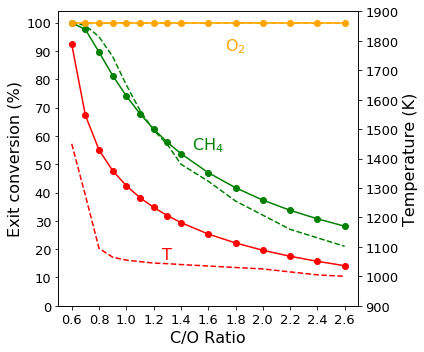

In [201]:
plt.figure(figsize=(6,5))
plt.plot(ratios_real, pch4_conv, 'bo-', label='CH4', color='g')
plt.annotate("CH$_4$", fontsize=16, color='g',xy=(1.6,60), va='top', ha='center')
plt.plot(ratios_real,ch4_horn, '--', color='g')
plt.plot(ratios_real, po2_conv, 'bo-', label='O2', color='orange')
plt.annotate("O$_2$", fontsize=16, color='orange',xy=(1.8,95), va='top', ha='center')
plt.plot(ratios_real,o2_horn, '--', color='orange')
# plt.legend()
plt.yticks(np.arange(0,106,10))
plt.ylabel('Exit conversion (%)', fontsize=16)
plt.xlabel('C/O Ratio', fontsize=16)
plt.xticks(np.arange(.6,2.7,0.2))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax2 = plt.twinx()
ax2.plot(ratios_real, end_temp, 'bo-', color='r')
ax2.set_ylim(900, 1900)
ax2.set_yticks(np.arange(900,2000,100))
for item in (ax2.get_yticklabels()):
             item.set_fontsize(13)
ax2.annotate("T",fontsize=16, color='r',
             xy=(1.3, 1100),
             va='top', ha='center')
ax2.set_ylabel('Temperature (K)', fontsize=16)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(13)
ax2.plot(ratios_real,t_horn,'--',color='r')
plt.tight_layout()
plt.savefig('paperplots/conversion.pdf', bbox_inches='tight', dpi=300)

In [202]:
pco_sel = [x *100 for x in co_sel]
ph2_sel = [x * 100 for x in h2_sel]
pco2_sel = [x * 100 for x in co2_sel]
ph2o_sel = [x * 100 for x in h2o_sel]

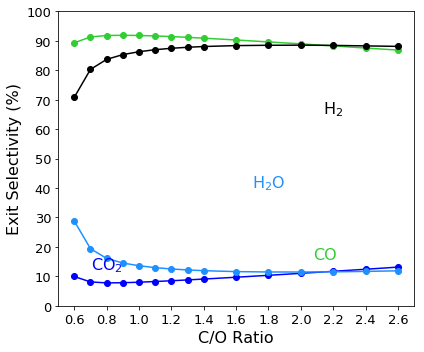

In [222]:
plt.figure(figsize=(6,5))
plt.plot(ratios_real, pco_sel, 'bo-', label='CO', color='limegreen')
plt.annotate("CO", fontsize=16, color='limegreen',xy=(2.15,20), va='top', ha='center')
plt.plot(ratios_real, ph2_sel, 'bo-', label='H2', color='k')
plt.annotate("H$_2$", fontsize=16, color='k',xy=(2.2,70), va='top', ha='center')
plt.plot(ratios_real, pco2_sel, 'bo-', label='CO2', color='blue')
plt.annotate("CO$_2$", fontsize=16, color='blue',xy=(0.8,17), va='top', ha='center')
plt.plot(ratios_real, ph2o_sel, 'bo-', label='H2O', color='dodgerblue')
plt.annotate("H$_2$O", fontsize=16, color='dodgerblue',xy=(1.8,45), va='top', ha='center')
plt.ylabel('Exit Selectivity (%)', fontsize=16)
plt.xlabel('C/O Ratio', fontsize=16)
plt.xticks(np.arange(.6,2.7,0.2))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.yticks(np.arange(0,101,10))
plt.tight_layout()
plt.savefig('paperplots/selectivity.pdf', bbox_inches='tight', dpi=300)

In [205]:
# horn data pt
# horn_co = [90,92,94,95,96,95,94,93,93,90,88,85,83,81,78]
# horn_h2 = [72,85,87,85,83,80,79,77,76,70,66,61,58,50,48]
# horn_h2o = [38,17,12,17,19,20,21,22,24,26,31,38,43,48,52]
# horn_co2 = [10,9,7,7,6,7,8,9,10,11,13,16,19,21,26]

# horn data rh
horn_co = [88,90,93,94,95,95,94,94,93,92,91,90,89,88,87]
horn_h2 = [79,88,95,94,93,92,91,90,89,88,85,84,80,78,76]
horn_h2o = [21,12,5,6,7,8,9,10,11,12,15,16,20,22,24]
horn_co2 = [12,10,7,6,5,5,6,6,7,8,9,10,11,12,13]

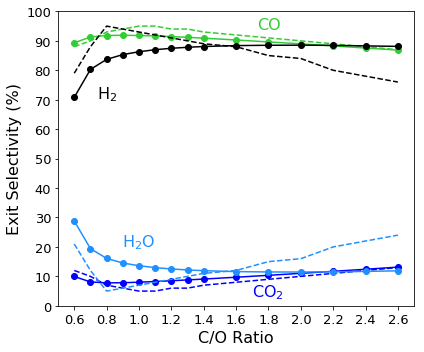

In [223]:
plt.figure(figsize=(6,5))
plt.plot(ratios_real, pco_sel, 'bo-', label='CO', color='limegreen')
plt.annotate("CO", fontsize=16, color='limegreen',xy=(1.8,98), va='top', ha='center')
plt.plot(ratios_real,horn_co,'--',color='limegreen')
plt.plot(ratios_real, ph2_sel, 'bo-', label='H2', color='k')
plt.annotate("H$_2$", fontsize=16, color='k',xy=(0.8,75), va='top', ha='center')
plt.plot(ratios_real, pco2_sel, 'bo-', label='CO2', color='blue')
plt.plot(ratios_real,horn_h2,'--',color='k')
plt.annotate("CO$_2$", fontsize=16, color='blue',xy=(1.8,8), va='top', ha='center')
plt.plot(ratios_real,horn_co2,'--',color='blue')
plt.plot(ratios_real, ph2o_sel, 'bo-', label='H2O', color='dodgerblue')
plt.annotate("H$_2$O", fontsize=16, color='dodgerblue',xy=(1.,25), va='top', ha='center')
plt.ylabel('Exit Selectivity (%)', fontsize=16)
plt.plot(ratios_real,horn_h2o,'--',color='dodgerblue')
plt.xlabel('C/O Ratio', fontsize=16)
plt.xticks(np.arange(.6,2.7,0.2))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.yticks(np.arange(0,101,10))
plt.tight_layout()
plt.savefig('paperplots/selectivity_comparison.pdf', bbox_inches='tight', dpi=300)

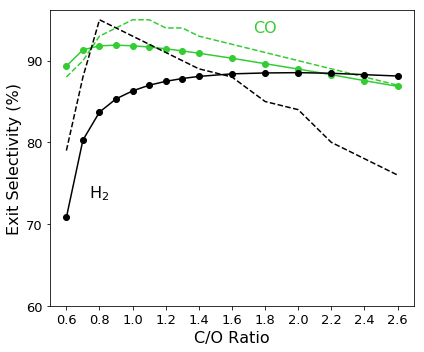

In [219]:
plt.figure(figsize=(6,5))
plt.plot(ratios_real, pco_sel, 'bo-', label='CO', color='limegreen')
plt.annotate("CO", fontsize=16, color='limegreen',xy=(1.8,95), va='top', ha='center')
plt.plot(ratios_real,horn_co,'--',color='limegreen')
plt.plot(ratios_real, ph2_sel, 'bo-', label='H2', color='k')
plt.annotate("H$_2$", fontsize=16, color='k',xy=(0.8,75), va='top', ha='center')
# plt.plot(ratios_real, pco2_sel, 'bo-', label='CO2', color='blue')
plt.plot(ratios_real,horn_h2,'--',color='k')
# plt.annotate("CO$_2$", fontsize=16, color='blue',xy=(1.8,8), va='top', ha='center')
# plt.plot(ratios_real,horn_co2,'--',color='blue')
# plt.plot(ratios_real, ph2o_sel, 'bo-', label='H2O', color='dodgerblue')
# plt.annotate("H$_2$O", fontsize=16, color='dodgerblue',xy=(1.,25), va='top', ha='center')
# plt.ylabel('Exit Selectivity (%)', fontsize=16)
# plt.plot(ratios_real,horn_h2o,'--',color='dodgerblue')
plt.ylabel('Exit Selectivity (%)', fontsize=16)
plt.xlabel('C/O Ratio', fontsize=16)
plt.xticks(np.arange(.6,2.7,0.2))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.yticks(np.arange(60,100,10))
plt.tight_layout()
plt.savefig('paperplots/selectivity_syngas.pdf', bbox_inches='tight', dpi=300)

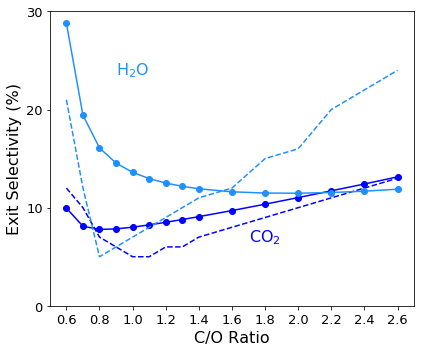

In [221]:
plt.figure(figsize=(6,5))
# plt.plot(ratios_real, pco_sel, 'bo-', label='CO', color='limegreen')
# plt.annotate("CO", fontsize=16, color='limegreen',xy=(1.8,98), va='top', ha='center')
# plt.plot(ratios_real,horn_co,'--',color='limegreen')
# plt.plot(ratios_real, ph2_sel, 'bo-', label='H2', color='k')
# plt.annotate("H$_2$", fontsize=16, color='k',xy=(0.8,75), va='top', ha='center')
plt.plot(ratios_real, pco2_sel, 'bo-', label='CO2', color='blue')
# plt.plot(ratios_real,horn_h2,'--',color='k')
plt.annotate("CO$_2$", fontsize=16, color='blue',xy=(1.8,8), va='top', ha='center')
plt.plot(ratios_real,horn_co2,'--',color='blue')
plt.plot(ratios_real, ph2o_sel, 'bo-', label='H2O', color='dodgerblue')
plt.annotate("H$_2$O", fontsize=16, color='dodgerblue',xy=(1.,25), va='top', ha='center')
plt.ylabel('Exit Selectivity (%)', fontsize=16)
plt.plot(ratios_real,horn_h2o,'--',color='dodgerblue')
plt.ylabel('Exit Selectivity (%)', fontsize=16)
plt.xlabel('C/O Ratio', fontsize=16)
plt.xticks(np.arange(.6,2.7,0.2))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.yticks(np.arange(0,40,10))
plt.tight_layout()
plt.savefig('paperplots/selectivity_full.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# plot all on one
temps = []
o2 = []
co = []
h2 = []
ratios = []
for r in data:
    gas_out, gas_names, dist_array, T_array = r[1]
    for x in range(len(r[1][1])):
        if r[1][1][x] == 'O2(3)':
            o2.append(r[1][0][:, x])
        if r[1][1][x] == 'CO(7)':
            co.append(r[1][0][:, x])
        if r[1][1][x] == 'H2(6)':
            h2.append(r[1][0][:, x])
    dist_array = r[1][2]
    temps.append(r[1][3])
    ratios.append(r[0])

sns.set_palette(sns.color_palette("hls", 15))
fig, axs = plt.subplots(3, 1)
# plot exit conversion and temp
for r in range(len(ratios)):
    axs[0].plot(dist_array, o2[r], label=ratios[r])
    axs[1].plot(dist_array, h2[r], label=ratios[r])
    axs[2].plot(dist_array, co[r], label=ratios[r])
ax2 = axs[0].twinx()
for r in range(len(ratios)):
    ax2.plot(dist_array, temps[r])
axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [-0.02, 0.2], linestyle='--', color='xkcd:grey')
axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [-0.02, 0.2], linestyle='--', color='xkcd:grey')
axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.08), va='bottom', ha='left')
# axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-0.02,.2], linestyle='--', color='xkcd:grey')
# axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-.02,0.2], linestyle='--', color='xkcd:grey')
# axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], .08), va =('bottom'), ha = ('left'))
# axs[2].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-.02,.2], linestyle='--', color='xkcd:grey')
# axs[2].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-.02,.2], linestyle='--', color='xkcd:grey')
# axs[2].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], .08), va =('bottom'), ha = ('left'))
axs[0].legend(loc='center left')
# axs[1].legend(loc='center left')
axs[0].set_ylabel('O2 Flow (mol/mm)', fontsize=13)
ax2.set_ylabel('Temperature (K)', fontsize=13)
# ax2.legend(loc='center right')
axs[0].set_xlabel('Position (mm)', fontsize=13)
axs[1].set_ylabel('H2 Flow (mol/min)', fontsize=13)
axs[2].set_ylabel('CO Flow (mol/min)', fontsize=13)
axs[1].set_xlabel('Position (mm)', fontsize=13)
axs[2].set_xlabel('Position (mm)', fontsize=13)
# axs[0].set_title('O2');axs[1].set_title('H2');axs[2].set_title('CO')
ax2.set_ylim(200, 2000)
axs[0].set_ylim(0, .1)
axs[0].set_xlim(5, 25)
axs[1].set_xlim(5, 25)
axs[2].set_xlim(5, 25)
# plt.tight_layout()
fig.set_figheight(14)
fig.set_figwidth(8)
out_dir = 'figures'
os.path.exists(out_dir) or os.makedirs(out_dir)
fig.savefig(out_dir + '/' + 'flows.pdf', bbox_inches='tight')